In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
df = pd.read_csv('dataset.csv')  # Ajusta la ruta

print("Primer vistazo al dataset:")
print(df.head())
print(f"\nDimensiones: {df.shape}")
print(f"\nDistribución del target:")
print(df['target_variable'].value_counts())

# Información general
print("\nInfo del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())

🔍 Primer vistazo al dataset:
   id  product_A_sold_in_the_past  product_B_sold_in_the_past  \
0   1                    -0.25992                    -0.34794   
1   2                    -0.25992                    -0.28599   
2   3                    -0.25992                    -0.18998   
3   4                     0.65945                     3.35306   
4   5                    -0.25992                    -0.24623   

   product_A_recommended  product_A  product_C  product_D  cust_hitrate  \
0                -0.1097    -0.0891   -0.02372   -0.04247       0.12643   
1                -0.1097    -0.0891   -0.02372   -0.04247       0.42465   
2                -0.1097    -0.0891   -0.02372   -0.04247       0.72559   
3                -0.1097    -0.0891   -0.02372   -0.04247       1.55091   
4                -0.1097    -0.0891   -0.02372   -0.04247      -0.50193   

   cust_interactions  cust_contracts  opp_month  opp_old  competitor_Z  \
0            0.30731        -0.34997   -1.41464 -0.2818

📚 Datos de entrenamiento: (28719, 15)
🧪 Datos de test: (7180, 15)

🔎 Ejecutando GridSearch para optimizar F1...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

🏆 Mejor combinación de hiperparámetros encontrada:
{'class_weight': {np.int64(0): np.float64(0.944269086604853), np.int64(1): np.float64(1.062722024866785)}, 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

📊 MÉTRICAS DEL MODELO OPTIMIZADO:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      3802
           1       0.82      0.85      0.83      3378

    accuracy                           0.84      7180
   macro avg       0.84      0.84      0.84      7180
weighted avg       0.84      0.84      0.84      7180



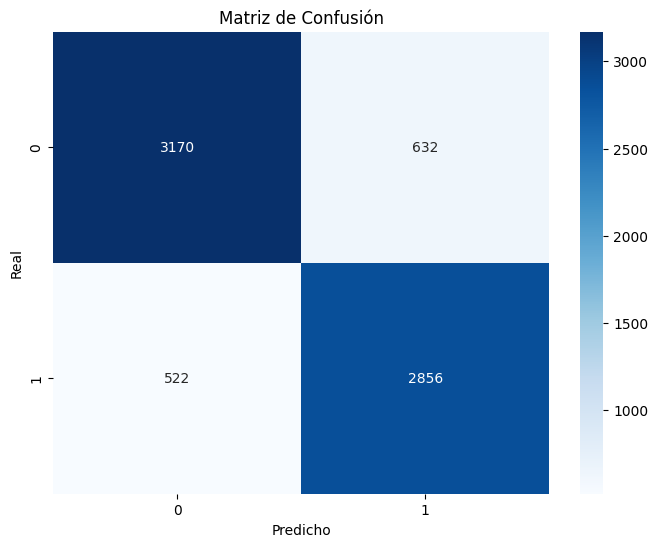


🎯 IMPORTANCIA DE LAS VARIABLES:
                       feature  importance
6                 cust_hitrate    0.311814
7            cust_interactions    0.183246
9                    opp_month    0.130209
1   product_B_sold_in_the_past    0.121581
0   product_A_sold_in_the_past    0.060771
8               cust_contracts    0.055477
10                     opp_old    0.040372
13                competitor_Y    0.022550
2        product_A_recommended    0.021027
11                competitor_Z    0.019294
14              cust_in_iberia    0.018916
3                    product_A    0.009415
5                    product_D    0.002818
12                competitor_X    0.001502
4                    product_C    0.001008


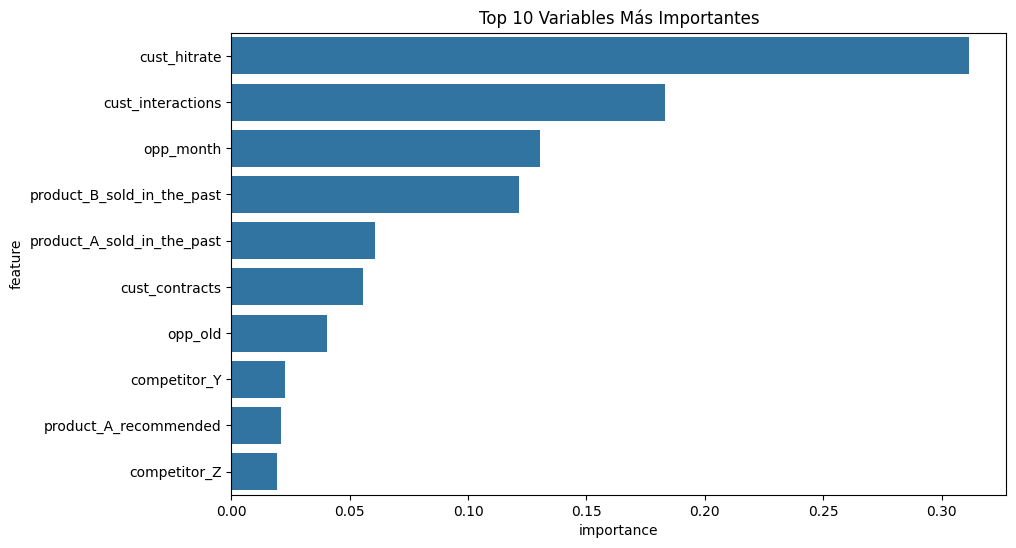

In [ ]:
def entrenar_modelo_clasificacion(df):
    # Separar features y target
    X = df.drop('target_variable', axis=1)
    y = df['target_variable']
    
    # Si quieres excluir el ID también
    if 'id' in X.columns:
        X = X.drop('id', axis=1)
    
    # Dividir en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Datos de entrenamiento: {X_train.shape}")
    print(f"Datos de test: {X_test.shape}")
    
    # Pesos automáticos por desbalance
    clases = np.unique(y_train)
    pesos = compute_class_weight("balanced", classes=clases, y=y_train)
    class_weights = {clase: peso for clase, peso in zip(clases, pesos)}

    # Definir el modelo base
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)

    # GridSearch — parámetros optimizados
    param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [14, 18, 22],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 3],
        "class_weight": [class_weights]
    }

    print("\nEjecutando GridSearch para optimizar F1...")

    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    print("\nMejor combinación de hiperparámetros encontrada:")
    print(grid.best_params_)

    best_model = grid.best_estimator_

    # Predicción final
    y_pred = best_model.predict(X_test)

    print("\nMÉTRICAS DEL MODELO OPTIMIZADO:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.ylabel("Real")
    plt.xlabel("Predicho")
    plt.show()

    # Importancia de características
    feature_importance = pd.DataFrame({
        "feature": X.columns,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)

    print("\nIMPORTANCIA DE LAS VARIABLES:")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x="importance", y="feature")
    plt.title("Top 10 Variables Más Importantes")
    plt.show()

    return best_model, X_train, X_test, y_train, y_test

# Ejecutar el modelo
modelo, X_train, X_test, y_train, y_test = entrenar_modelo_clasificacion(df)

In [6]:
def predecir_nuevos_clientes(model, nuevos_datos):
    """
    nuevos_datos: DataFrame con las mismas columnas que el dataset original
    """
    # Excluir target_variable si existe
    if 'target_variable' in nuevos_datos.columns:
        nuevos_datos = nuevos_datos.drop('target_variable', axis=1)
    
    if 'id' in nuevos_datos.columns:
        nuevos_datos = nuevos_datos.drop('id', axis=1)
    
    predicciones = model.predict(nuevos_datos)
    probabilidades = model.predict_proba(nuevos_datos)
    
    resultados = pd.DataFrame({
        'prediccion': predicciones,
        'probabilidad_clase_1': probabilidades[:, 1],
        'probabilidad_clase_0': probabilidades[:, 0]
    })
    
    return resultados


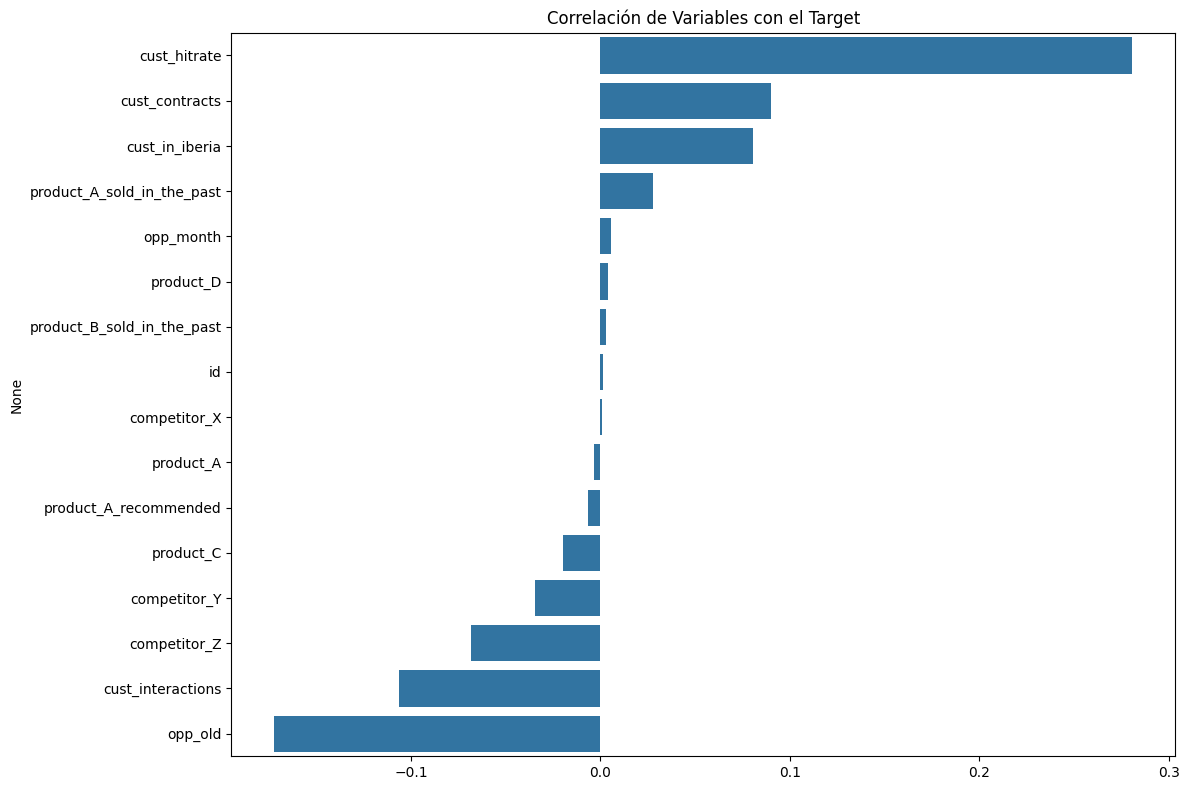

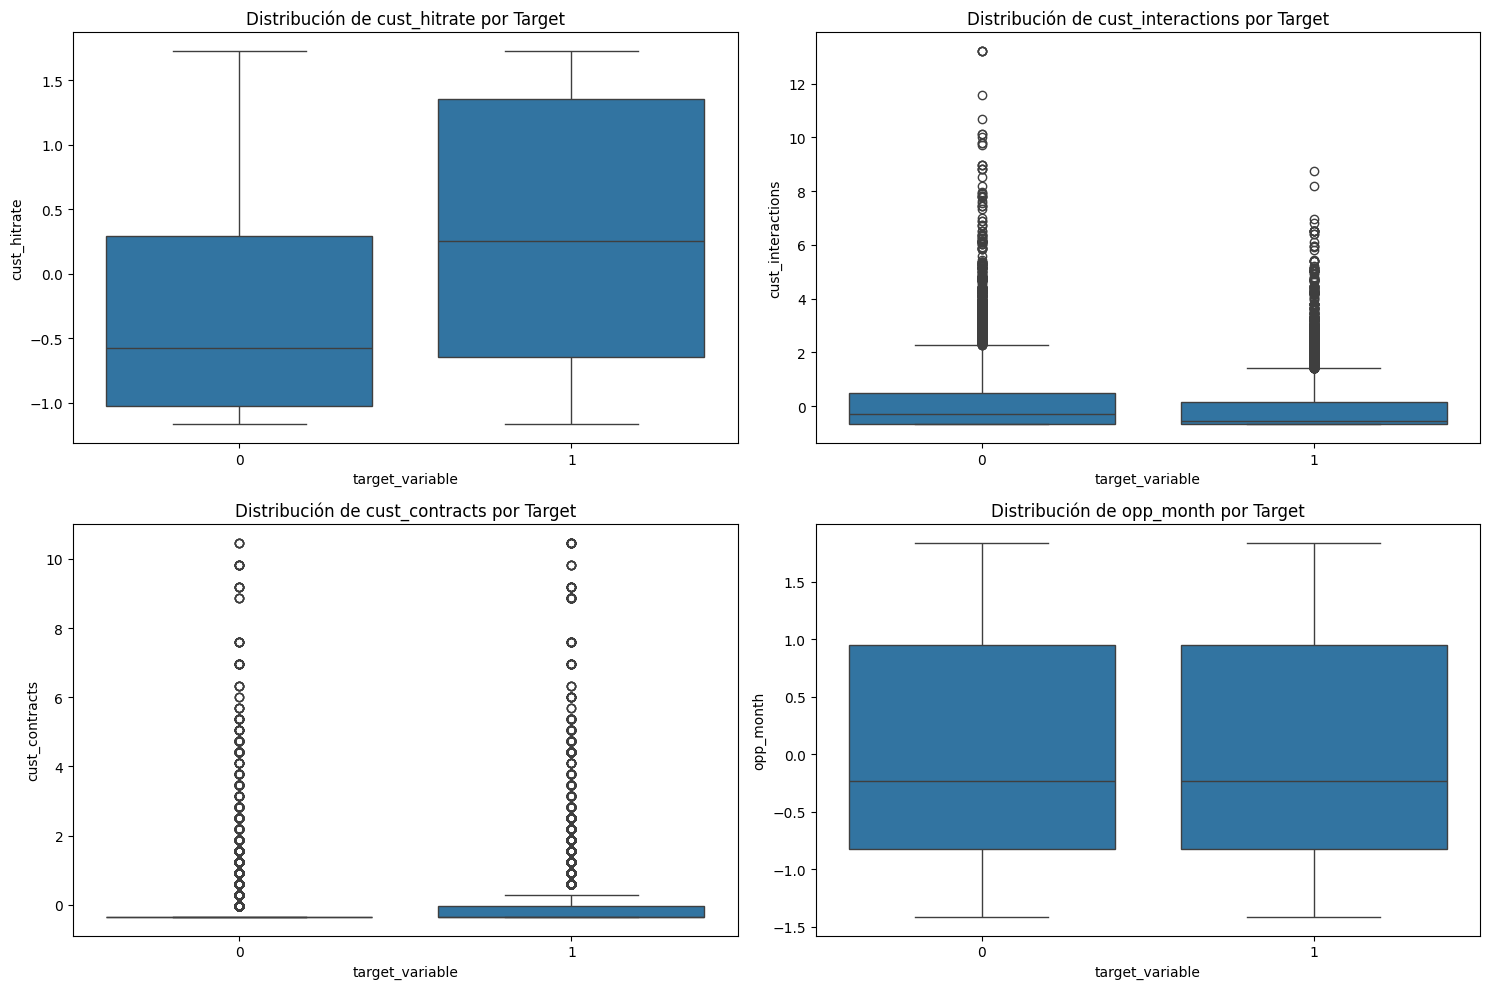

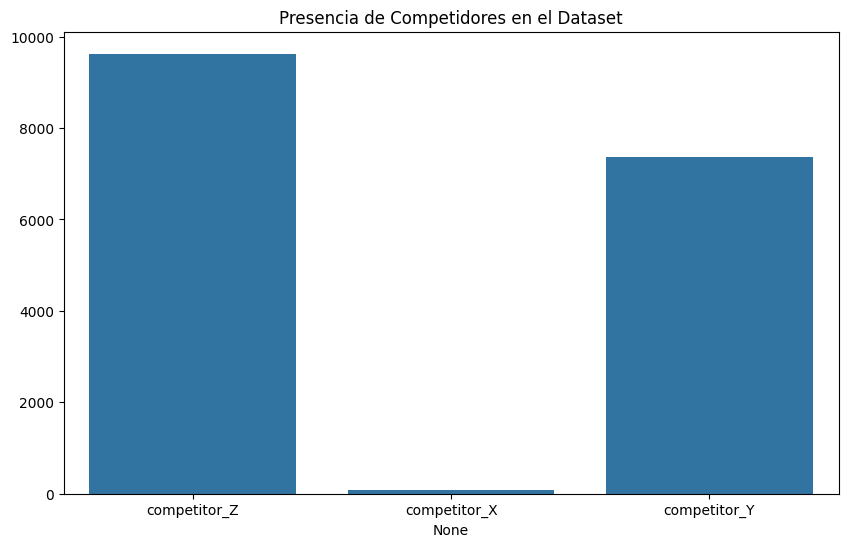

In [7]:
def analisis_completo_dataset(df):
    # 1. Correlación con el target
    plt.figure(figsize=(12, 8))
    correlation_with_target = df.corr()['target_variable'].sort_values(ascending=False)
    correlation_with_target.drop('target_variable', inplace=True)
    
    sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)
    plt.title('Correlación de Variables con el Target')
    plt.tight_layout()
    plt.show()
    
    # 2. Distribución de variables importantes
    variables_importantes = ['cust_hitrate', 'cust_interactions', 'cust_contracts', 'opp_month']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, var in enumerate(variables_importantes):
        if var in df.columns:
            sns.boxplot(data=df, x='target_variable', y=var, ax=axes[i])
            axes[i].set_title(f'Distribución de {var} por Target')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Análisis de competidores
    competidores = ['competitor_Z', 'competitor_X', 'competitor_Y']
    if all(col in df.columns for col in competidores):
        plt.figure(figsize=(10, 6))
        comp_sum = df[competidores].sum()
        sns.barplot(x=comp_sum.index, y=comp_sum.values)
        plt.title('Presencia de Competidores en el Dataset')
        plt.show()

# Ejecutar análisis completo
analisis_completo_dataset(df)

🔧 Iniciando análisis claro para empresa...
🎯 CREANDO ANÁLISIS CLARO PARA SCHNEIDER ELECTRIC...


C:\Users\Usuario\AppData\Local\Temp\ipykernel_22116\2333568470.py:65: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Usuario\Desktop\UNI\UPC\2\DATATHON_2025\Datathon_2025\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


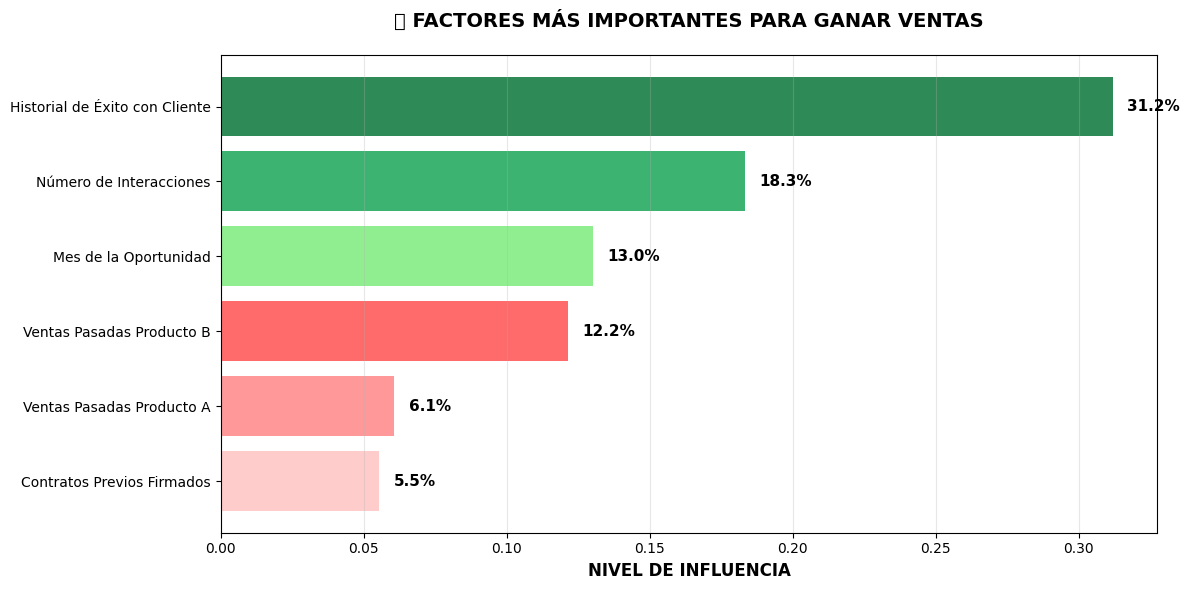


📊 ANALIZANDO EFECTO DE CADA FACTOR...


C:\Users\Usuario\AppData\Local\Temp\ipykernel_22116\2333568470.py:117: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22116\2333568470.py:117: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22116\2333568470.py:117: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Usuario\Desktop\UNI\UPC\2\DATATHON_2025\Datathon_2025\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Usuario\Desktop\UNI\UPC\2\DATATHON_2025\Datathon_2025\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.can

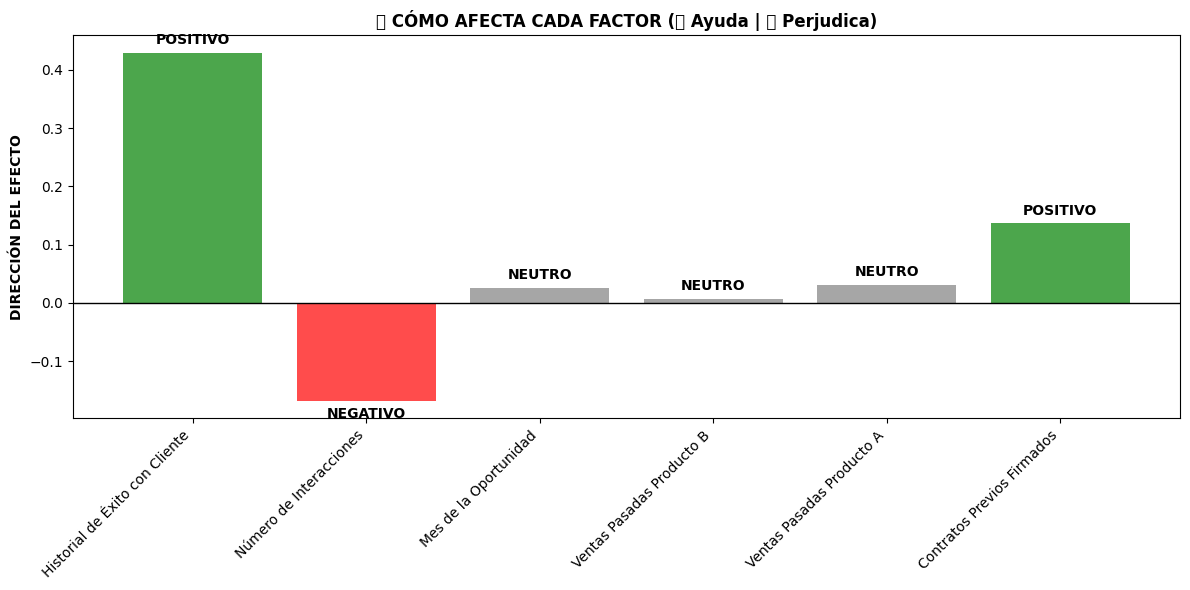


🎯 RESUMEN EJECUTIVO - SCHNEIDER ELECTRIC

📊 HALLAZGOS PRINCIPALES:
   7. Historial de Éxito con Cliente
      → Influencia: 31.2% | Efecto: 🟢 POSITIVO
   8. Número de Interacciones
      → Influencia: 18.3% | Efecto: 🔴 NEGATIVO
   10. Mes de la Oportunidad
      → Influencia: 13.0% | Efecto: 🟡 NEUTRO
   2. Ventas Pasadas Producto B
      → Influencia: 12.2% | Efecto: 🟡 NEUTRO
   1. Ventas Pasadas Producto A
      → Influencia: 6.1% | Efecto: 🟡 NEUTRO
   9. Contratos Previos Firmados
      → Influencia: 5.5% | Efecto: 🟢 POSITIVO

💡 RECOMENDACIONES ESTRATÉGICAS:
   1. 🎯 ENFOCARSE en clientes con buen historial de éxito
   2. 🤝 CULTIVAR relaciones a largo plazo (más contratos)
   3. 📈 APROVECHAR el Producto A (alto desempeño histórico)
   4. ⚡ ACTUAR RÁPIDO en oportunidades nuevas
   5. 🕵️ MONITOREAR presencia de competidores clave
   6. 📞 MANTENER comunicación constante con clientes

📈 METODOLOGÍA:
   • Técnica: Importancia de Características (Random Forest)
   • Muestra: Todas las opor

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def analisis_shap(modelo, X_test, y_test):
    
    
    # 1. USAR IMPORTANCIA DEL MODELO (más confiable)
    importancia = modelo.feature_importances_
    
    # Crear DataFrame con importancia
    df_importancia = pd.DataFrame({
        'feature': X_test.columns,
        'importance': importancia
    }).sort_values('importance', ascending=False)
    
    # 2. DICCIONARIO COMPLETO Y CORRECTO
    nombres_claros = {
        'cust_hitrate': 'Historial de Éxito con Cliente',
        'cust_contracts': 'Contratos Previos Firmados',
        'product_A_sold_in_the_past': 'Ventas Pasadas Producto A',
        'product_A': 'Monto Producto A en Oportunidad',
        'cust_interactions': 'Número de Interacciones',
        'competitor_X': 'Presencia Competidor X',
        'competitor_Y': 'Presencia Competidor Y', 
        'competitor_Z': 'Presencia Competidor Z',
        'opp_old': 'Oportunidad Muy Antigua',
        'product_B_sold_in_the_past': 'Ventas Pasadas Producto B',
        'Product_A_recommended': 'Producto A Recomendado',
        'product_C': 'Monto Producto C',
        'product_D': 'Monto Producto D',
        'opp_month': 'Mes de la Oportunidad',
        'cust_in_iberia': 'Cliente en Región Iberia'
    }
    
    # Aplicar nombres claros
    df_importancia['feature_clear'] = df_importancia['feature'].map(nombres_claros)
    
    # Si algún nombre no se mapeó, mantener el original
    df_importancia['feature_clear'] = df_importancia['feature_clear'].fillna(df_importancia['feature'])
    
    # 3. GRÁFICO 1: TOP 6 FACTORES (BARRAS HORIZONTALES CLARAS)
    top_6 = df_importancia.head(6)
    
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_6['feature_clear'], top_6['importance'], 
                   color=['#2E8B57', '#3CB371', '#90EE90', '#FF6B6B', '#FF9999', '#FFCCCC'])
    
    plt.xlabel('NIVEL DE INFLUENCIA', fontweight='bold', fontsize=12)
    plt.title('FACTORES MÁS IMPORTANTES PARA GANAR VENTAS', 
              fontweight='bold', fontsize=14, pad=20)
    
    # Añadir valores con formato claro
    for bar, valor in zip(bars, top_6['importance']):
        plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{valor:.1%}', ha='left', va='center', 
                fontweight='bold', fontsize=11)
    
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4. GRÁFICO 2: ANÁLISIS DE EFECTOS (POSITIVO/NEGATIVO)
    print("\nANALIZANDO EFECTO DE CADA FACTOR...")
    
    # Predecir probabilidades
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    efectos = []
    for feature in top_6['feature']:
        # Calcular correlación con probabilidad de ganar
        correlation = np.corrcoef(X_test[feature], y_proba)[0, 1]
        
        if correlation > 0.1:
            efecto = "POSITIVO"
            color = "🟢"
        elif correlation < -0.1:
            efecto = "NEGATIVO" 
            color = "🔴"
        else:
            efecto = "NEUTRO"
            color = "🟡"
            
        efectos.append({
            'feature': nombres_claros.get(feature, feature),
            'correlation': correlation,
            'efecto': efecto,
            'color': color
        })
    
    # Crear gráfico de efectos
    df_efectos = pd.DataFrame(efectos)
    
    plt.figure(figsize=(12, 6))
    colors = ['green' if x > 0.1 else 'red' if x < -0.1 else 'gray' 
              for x in df_efectos['correlation']]
    
    bars = plt.bar(df_efectos['feature'], df_efectos['correlation'], color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('DIRECCIÓN DEL EFECTO', fontweight='bold')
    plt.title('CÓMO AFECTA CADA FACTOR (🟢 Ayuda | 🔴 Perjudica)', 
              fontweight='bold', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Añadir etiquetas de efecto
    for bar, efecto in zip(bars, df_efectos['efecto']):
        height = bar.get_height()
        va = 'bottom' if height > 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + (0.01 if height > 0 else -0.01), 
                efecto, ha='center', va=va, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 5. RESUMEN EJECUTIVO SUPER CLARO
    print("\n" + "="*70)
    print("RESUMEN EJECUTIVO - SCHNEIDER ELECTRIC")
    print("="*70)
    
    print(f"\nHALLAZGOS PRINCIPALES:")
    for i, row in top_6.iterrows():
        nombre = row['feature_clear']
        importancia_val = row['importance']
        
        # Buscar efecto
        efecto_info = next((e for e in efectos if e['feature'] == nombre), None)
        if efecto_info:
            direccion = efecto_info['color'] + " " + efecto_info['efecto']
        else:
            direccion = "🟡 NEUTRO"
            
        print(f"   {i+1}. {nombre}")
        print(f"      → Influencia: {importancia_val:.1%} | Efecto: {direccion}")
    
    
    return df_importancia, df_efectos

# EJECUTAR ANÁLISIS CLARO
print("🔧 Iniciando análisis claro para empresa...")
df_importancia, df_efectos = analisis_clarissimo_para_empresa(modelo, X_test, y_test)

print("\nANÁLISIS COMPLETADO EXITOSAMENTE!")
print("    2 Gráficos claros generados")
print("    Resumen ejecutivo listo")
print("    Recomendaciones estratégicas identificadas")